# Anomaly Detection with GANs for Multivariate Time Series
https://arxiv.org/pdf/1809.04758.pdf

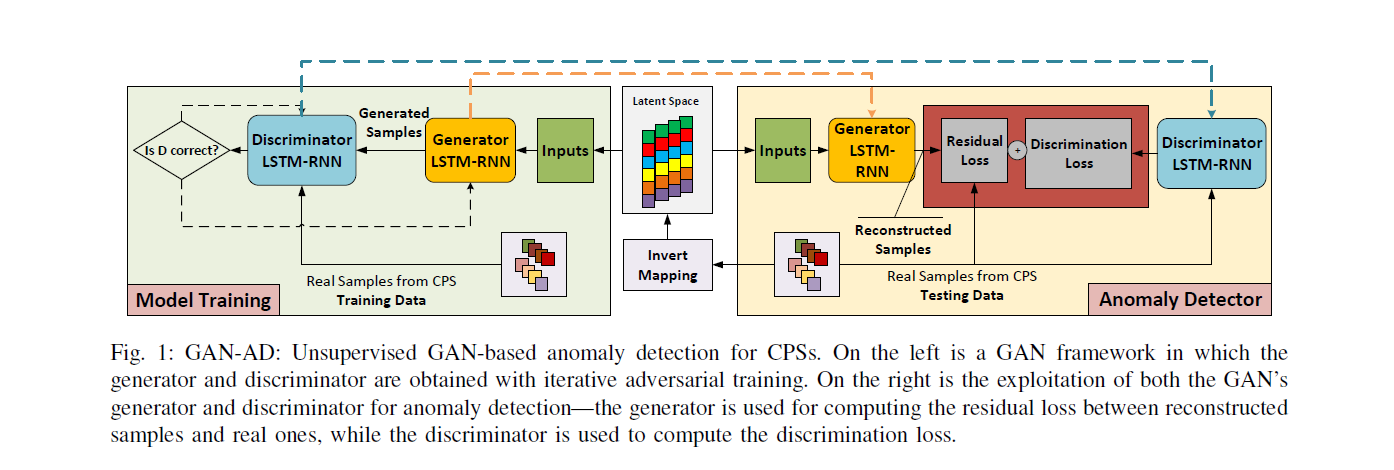

In [2]:
import os
import pandas as pd
import numpy as np
import random
from datetime import date
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from time_series_anomaly_detection.detector import GAN_AD

# Skoltech Anomaly Benchmark (SKAB) dataset

Iurii D. Katser and Vyacheslav O. Kozitsin, “Skoltech Anomaly Benchmark (SKAB).” Kaggle, 2020, doi: 10.34740/KAGGLE/DSV/1693952.

https://www.kaggle.com/yuriykatser/skoltech-anomaly-benchmark-skab <br>
https://github.com/waico/SKAB

## Data preparation

In [3]:
# single multivariate time series
dataset_name = "16.csv"
df_original = pd.read_csv("../datasets/skab/other/" + dataset_name, index_col='datetime', sep=';',parse_dates=True).reset_index(drop=True)

Original data - example visualisation

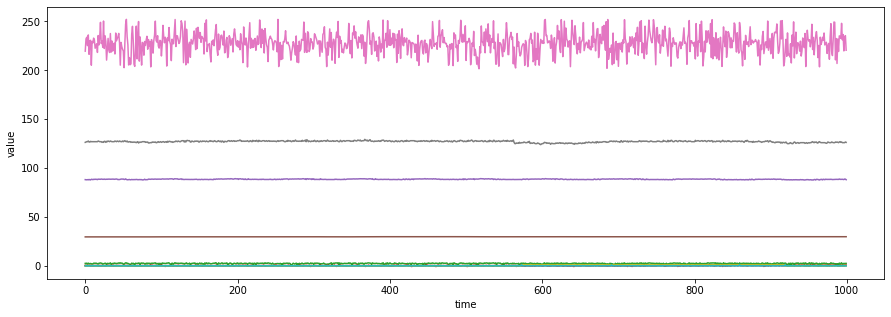

In [4]:
display(Markdown('Original data - example visualisation'))
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('value')
plt.plot(df_original[:1000])
plt.show()

In [5]:
display(df_original[df_original['changepoint'] == 1.0])

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
573,0.214007,0.257693,2.67899,0.054711,88.1087,29.7510,223.592,126.000,1.0,1.0
691,0.216232,0.259254,2.38235,0.382638,88.8730,29.7555,225.919,127.682,1.0,1.0
859,0.543127,0.623899,3.01024,0.382638,88.1912,29.8079,248.884,127.682,1.0,1.0
919,0.640217,0.712873,2.88289,0.054711,88.0661,29.8222,221.186,126.000,0.0,1.0


In [6]:
anomalies_index = np.array(df_original[df_original['anomaly'] == 1.0].index)

In [7]:
# dataset contains multiple anomalies, which will be used to create the test data
anomalies_index

array([573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585,
       586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598,
       599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611,
       612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624,
       625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637,
       638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650,
       651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663,
       664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676,
       677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689,
       690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702,
       703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715,
       716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728,
       729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741,
       742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 75

In [8]:
# anomaly indices are consecutive (all the records between the first and the last anomaly are labelled as anomalies)
df_original.iloc[anomalies_index]['anomaly'].value_counts()

1.0    346
Name: anomaly, dtype: int64

In [9]:
# create test (single multivariate time series) dataset from the anomalies and neighbouring data points
padding = 5
df_test = df_original.iloc[min(anomalies_index)-padding:max(anomalies_index)+padding,:].copy().reset_index(drop=True)
df_test_labels = pd.DataFrame(df_test.pop('anomaly'), columns=['anomaly'])
df_test.drop(columns=['changepoint'], inplace=True)
df_test['id'] = 0

In [10]:
# create train (multiple univariate time series) dataset without the anomalies and neighbouring data points
df_train_0 = df_original.iloc[:min(anomalies_index)-padding,:].copy()
df_train_1 = df_original.iloc[max(anomalies_index)+padding:,:].copy()

df_train_0['id'] = 0
df_train_1['id'] = 1

df_train = pd.concat([df_train_0, df_train_1], ignore_index=True)
df_train.drop(columns=['anomaly','changepoint'], inplace=True)

## Hyperparameter settings

The selected values appeared during the performed experiments as quite promising. 
"Finer" search was not conducted as this is only a toy-example demonstration, and the detector won't be used on this data.
I recommend using coarse to fine technique to find the most optimal set of hyper-parameters if needed.

In [11]:
window_size = 16
shift = 5
batch_size = 32
latent_dim = 2 
epochs = 20000
threshold = 0.5

## Training

In [ ]:
gan_ad = GAN_AD(window_size=window_size, shift=shift, batch_size=batch_size, latent_dim=latent_dim, id_columns=['id'])
gan_ad.fit(df_train, epochs, save_checkpoints=True, enable_prints=True)

#### As the loss function in the last training epochs deteriorated, I used the weights from the model saved in the 17000th epoch.

In [13]:
# gan_ad.load_weights("gan_ad_2021-10-24_epoch_17000.h5")
# gan_ad.fit_scaler(df_train.drop(columns=['id']))

## Evaluation demonstration

### Anomaly free (training) data

In [14]:
# data shorter than one window returns NaN Series
anomaly_scores = gan_ad.predict_anomaly_scores(pd.DataFrame(df_train[0:0+window_size-5]))
anomaly_scores

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    NaN
10   NaN
dtype: float64

Anomaly free (training) data with NaNs - anomaly scores

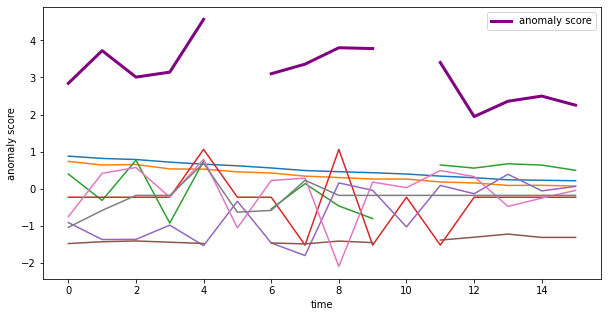

In [17]:
# one window with NaN values
window_with_nan = pd.DataFrame(df_train[0:0+window_size].copy())
window_with_nan.iloc[[5,10], [2,5]] = np.nan

display(Markdown('Anomaly free (training) data with NaNs - anomaly scores'))
anomaly_scores = gan_ad.predict_anomaly_scores(window_with_nan)
data = gan_ad.transform_data(window_with_nan.drop(columns=['id']))
plt.figure(figsize=(10,5))
plt.xlabel('time')
plt.ylabel('anomaly score')
plt.plot(data)
plt.plot(anomaly_scores, color='purple', lw=3, label='anomaly score')
plt.legend()
plt.show()

Anomaly free (training) data - anomaly scores

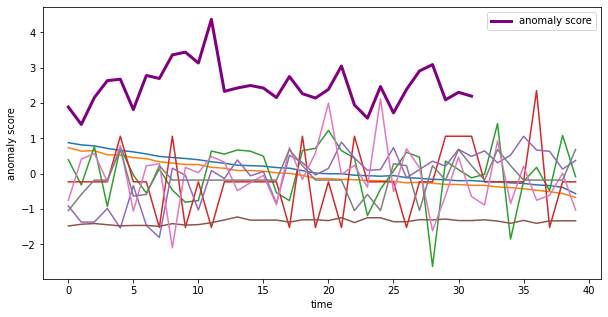

In [18]:
# more than one window
display(Markdown('Anomaly free (training) data - anomaly scores'))
anomaly_scores = gan_ad.predict_anomaly_scores(pd.DataFrame(df_train[0:(2*window_size)+8]))
data = gan_ad.transform_data(pd.DataFrame(df_train[0:(2*window_size)+8]).drop(columns=['id']))
plt.figure(figsize=(10,5))
plt.xlabel('time')
plt.ylabel('anomaly score')
plt.plot(data)
plt.plot(anomaly_scores, color='purple', lw=3, label='anomaly score')
plt.legend()
plt.show()

In [21]:
# average anomaly score
anomaly_scores = gan_ad.predict_anomaly_scores(pd.DataFrame(df_train[0:(20*window_size)]))
avg_score = anomaly_scores.sum()/(20*window_size)
display(Markdown('Anomaly free (training) data - Average anomaly score: %.2f' % avg_score))

Anomaly free (training) data - Average anomaly score: 2.75

### Test data with anomalies

Original data with anomalies

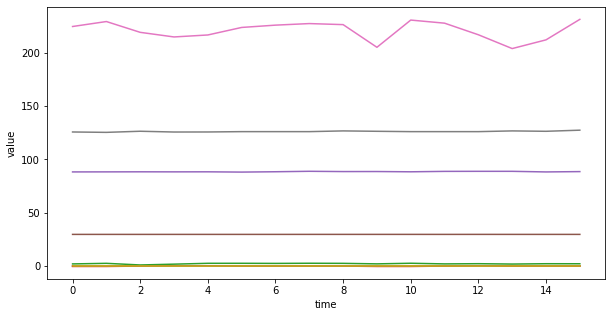

Scaled data with anomalies - true anomalies

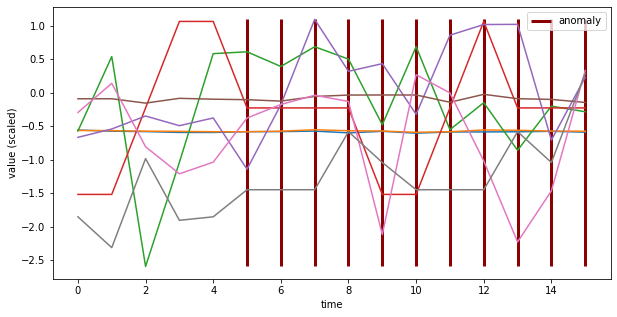

Scaled data with anomalies - predicted anomaly scores

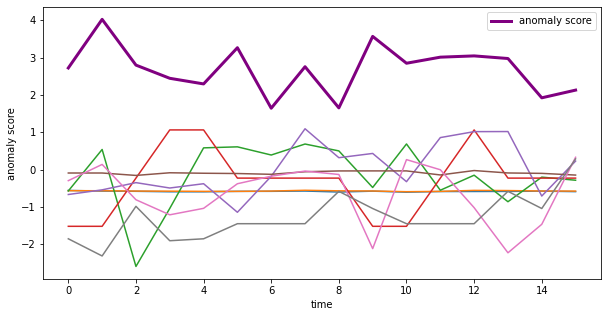

Scaled data with anomalies - predicted anomalies

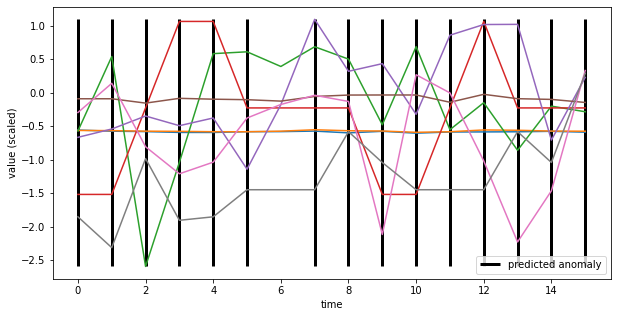

In [28]:
# one window
display(Markdown('Original data with anomalies'))
data = pd.DataFrame(df_test[0:window_size])
plt.figure(figsize=(10,5))
plt.xlabel('time')
plt.ylabel('value')
plt.plot(data)
plt.show()

display(Markdown('Scaled data with anomalies - true anomalies'))
data = gan_ad.transform_data(pd.DataFrame(df_test[0:window_size]).drop(columns=['id']))
plt.figure(figsize=(10,5))
plt.xlabel('time')
plt.ylabel("value (scaled)")
plt.plot(data)
labels = pd.DataFrame(df_test_labels[0:window_size]).replace(0,np.nan).dropna().index
plt.vlines(x=labels, ymin=np.min(np.min(data)), ymax=np.max(np.max(data)), colors='darkred', ls='-', lw=3, label='anomaly')
plt.legend()
plt.show()

display(Markdown('Scaled data with anomalies - predicted anomaly scores'))
anomaly_scores = gan_ad.predict_anomaly_scores(pd.DataFrame(df_test[0:0+window_size]))
plt.figure(figsize=(10,5))
plt.xlabel('time')
plt.ylabel('anomaly score')
plt.plot(data)
plt.plot(anomaly_scores, color='purple', lw=3, label='anomaly score')
plt.legend()
plt.show()

display(Markdown('Scaled data with anomalies - predicted anomalies'))
predicted = gan_ad.identify_anomaly(pd.DataFrame(df_test[0:window_size]), threshold = threshold)
predicted_labels = pd.DataFrame(predicted).replace(0,np.nan).dropna().index
plt.figure(figsize=(10,5))
plt.xlabel('time')
plt.ylabel("value (scaled)")
plt.plot(data)
plt.vlines(x=predicted_labels, ymin=np.min(np.min(data)), ymax=np.max(np.max(data)), colors='black', ls='-', lw=3, label='predicted anomaly')
plt.legend()
plt.show()

Original data with anomalies

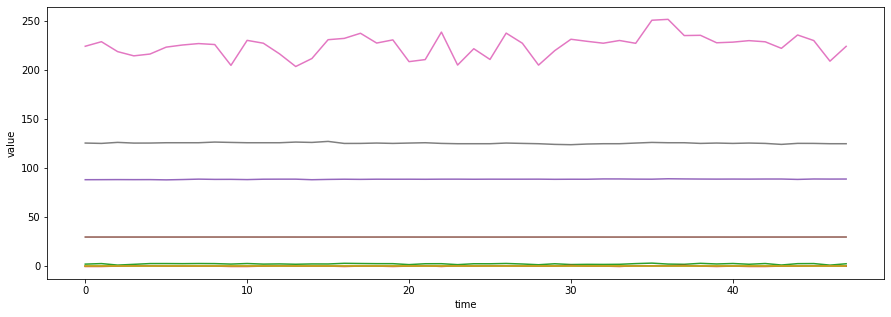

Scaled data with anomalies - true anomalies

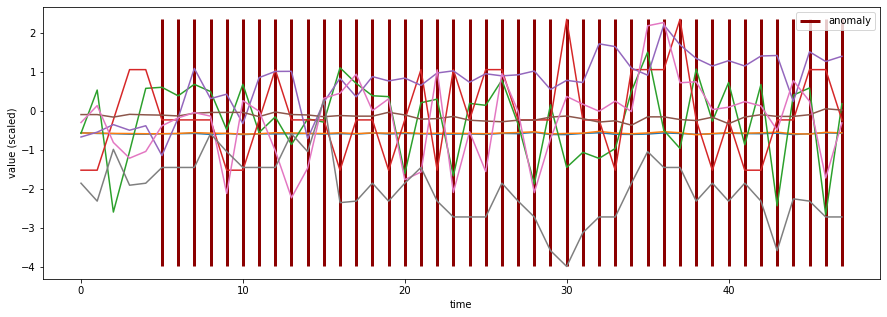

Scaled data with anomalies - predicted anomaly scores

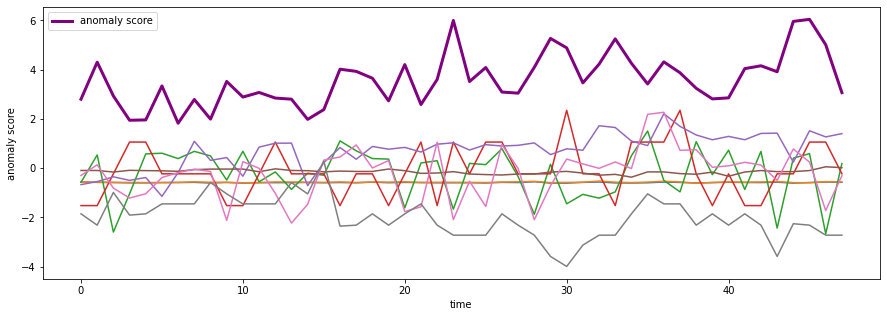

Scaled data with anomalies - predicted anomalies

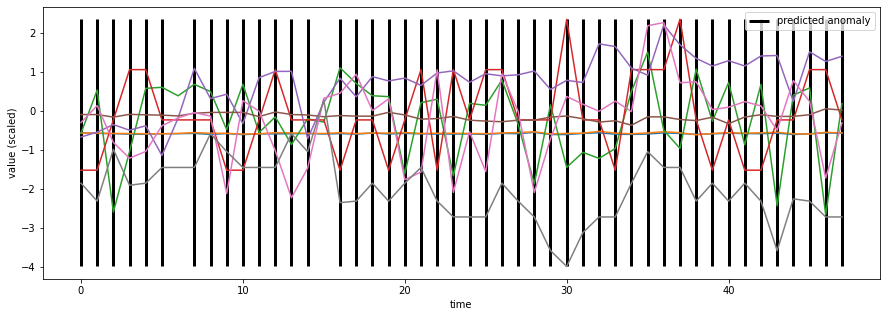

In [30]:
# more than one window
display(Markdown('Original data with anomalies'))
data = pd.DataFrame(df_test[0:(3*window_size)])
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('value')
plt.plot(data)
plt.show()

display(Markdown('Scaled data with anomalies - true anomalies'))
data = gan_ad.transform_data(pd.DataFrame(df_test[0:(3*window_size)]).drop(columns=['id']))
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel("value (scaled)")
plt.plot(data)
labels = pd.DataFrame(df_test_labels[0:(3*window_size)]).replace(0,np.nan).dropna().index
plt.vlines(x=labels, ymin=np.min(np.min(data)), ymax=np.max(np.max(data)), colors='darkred', ls='-', lw=3, label='anomaly')
plt.legend()
plt.show()

display(Markdown('Scaled data with anomalies - predicted anomaly scores'))
anomaly_scores = gan_ad.predict_anomaly_scores(pd.DataFrame(df_test[0:(3*window_size)]))
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('anomaly score')
plt.plot(data)
plt.plot(anomaly_scores, color='purple', lw=3, label='anomaly score')
plt.legend()
plt.show()

display(Markdown('Scaled data with anomalies - predicted anomalies'))
predicted = gan_ad.identify_anomaly(pd.DataFrame(df_test[0:(3*window_size)]), threshold=threshold)
predicted_labels = pd.DataFrame(predicted).replace(0,np.nan).dropna().index
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel("value (scaled)")
plt.plot(data)
plt.vlines(x=predicted_labels, ymin=np.min(np.min(data)), ymax=np.max(np.max(data)), colors='black', ls='-', lw=3, label='predicted anomaly')
plt.legend()
plt.show()

In [24]:
# average anomaly score
anomaly_scores = gan_ad.predict_anomaly_scores(pd.DataFrame(df_test[0:(20*window_size)]))
avg_score = anomaly_scores.sum()/(20*window_size)
display(Markdown('Data with anomalies - Average anomaly score: %.2f' % avg_score))

Data with anomalies - Average anomaly score: 3.18

In [25]:
y_true = np.array(df_test_labels[0:(20*window_size)])

In [26]:
predicted = gan_ad.identify_anomaly(pd.DataFrame(df_test[0:(20*window_size)]), threshold = threshold)
y_pred = np.array(predicted)

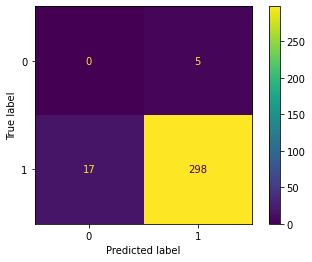

In [27]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))
disp.plot()